In [48]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# module for working with operating system
import os

# module for fetching item from its operand
from operator import itemgetter

# opencv library
import cv2
# computational library
import numpy as np
# pytorch imports
import torch
# import primitives to build our custom model
import torch.nn as nn
# optimizer
import torch.optim as optim
# visualization library
# model zoo with pretrained models
import torchvision.models as models
# some extended pytorch primitives
import torch.nn.functional as F

# augmentation imports
from torch.optim.lr_scheduler import MultiStepLR,CyclicLR

from collections import defaultdict, deque

import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from torchvision import transforms
import random
from torch.utils.data import DataLoader, Dataset, sampler
import pdb
import time
import warnings
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import functional as F
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import copy
from torch.autograd import Variable
import torchvision.transforms.functional as TF
from matplotlib import colors, cm, pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, f1_score
import torchvision
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
df=pd.read_csv("./data_all/train.csv")
train_df,val_df= train_test_split(df, test_size=0.2,random_state=42)

In [50]:
test_df=pd.read_csv("./data_all/test.csv")

In [52]:
bz=10
sz1=360
sz2=640

In [53]:
# define Focal loss
class FocalLoss(nn.Module):
    """
        Implementation of the Focal Loss function.

        Arguments:
            num_classes (int): number of classes.
                valid_labels: 0,..., num_classes - 1
                ignore_index: num_classes
            gamma (float): parameter which control slope of loss function.
    """
    def __init__(self, num_classes=12, gamma=2.0, ignore_indices=-1):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.gamma = gamma
        self.loss_fn = nn.CrossEntropyLoss(reduction='none', ignore_index=12)
        self.alpha =1
    # define forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is 
                (B, num_classes, H, W).
                targets (torch.LongTensor): tensor of ground-truth labels. The shape of the tensor is 
                (B, 1, H, W).
        """
        #target = torch.reshape(target,(4,300,300))
        loss_ce = self.loss_fn(pred_logits,target.long())
        #pt = torch.exp(-loss_ce)
        loss_focal = (1.0 - loss_ce.mul(-1).exp()).pow(self.gamma) * loss_ce
        #loss_focal = self.alpha * (1-pt)**self.gamma * loss_ce
        return loss_focal.mean()

In [54]:
# define soft-Jaccard loss
class SoftJaccardLoss(nn.Module):
    """
        Implementation of the Soft-Jaccard Loss function.

        Arguments:
            num_classes (int): number of classes.
            eps (float): value of the floating point epsilon.
    """
    def __init__(self, num_classes=12, eps=1e-5):
        super().__init__()
        # init fields
        self.num_classes = num_classes
        self.eps = eps

    # define forward pass
    def forward(self, pred_logits, targets):
        """
            Compute Soft-Jaccard Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is (B, num_classes, H, W).
                targets (torch.LongTensor): tensor of ground-truth labels. The shape of the tensor is (B, 1, H, W).
        """
        # get predictions from logits
        preds = pred_logits.softmax(dim=1)
        loss = 0
        # iterate over all classes
        for cls in range(self.num_classes):
            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection of predictions and targets
            intersection = (pred * target).sum()
            #print(intersection)

            sum_ = (pred + target).sum()
            # compute iou
            iou = (intersection + self.eps) / (sum_ - intersection + self.eps)
            #print(1-iou)

            # compute negative logarithm from the obtained dice coefficient
            loss = loss - iou.log()

            # get mean loss by class value
            loss = loss / self.num_classes

        return loss

In [55]:
 # create SoftDiceLoss class inherited from nn.Module
class SoftDiceLoss(nn.Module):
    """
        Implementation of the Soft-Dice Loss function.

        Arguments:
            num_classes (int): number of classes.
            eps (float): value of the floating point epsilon.
    """
    def __init__(self, num_classes, eps=1e-5):
        super().__init__()
        # init class fields
        self.num_classes = num_classes
        self.eps = eps

    # define the forward pass
    def forward(self, pred_logits, targets):  # pylint: disable=unused-argument
        """
            Compute Soft-Dice Loss.

            Arguments:
                preds (torch.FloatTensor):
                    tensor of predicted labels. The shape of the tensor is (B, num_classes, H, W).
                targets (torch.LongTensor):
                    tensor of ground-truth labels. The shape of the tensor is (B, 1, H, W).
            Returns:
                mean_loss (float32): mean loss by class  value.
        """
        preds = pred_logits.softmax(dim=1)

        loss = 0
        # iterate over all classes
        for cls in range(self.num_classes):
            # get ground truth for the current class
            target = (targets == cls).float()

            # get prediction for the current class
            pred = preds[:, cls]

            # calculate intersection
            intersection = (pred * target).sum()

            # compute dice coefficient
            dice = (2 * intersection + self.eps) / (pred.sum() + target.sum() + self.eps)

            # compute negative logarithm from the obtained dice coefficient
            loss = loss - dice.log()

            # get mean loss by class value
        loss = loss / self.num_classes

        return loss

In [56]:
# define semantic segmentation loss
class SemanticSegmentationLoss(nn.Module):
    """
        Implementation of the multi-objective loss function for semantic segmentation.

        Arguments:
            num_classes (int): number of classes.
            jaccard_alpha (float): weight of the SoftJaccardLoss
    """
    def __init__(self, num_classes=12, jaccard_alpha=0.9, ignore_indices=12):
        super().__init__()
        # init fields
        self.jaccard_alpha = jaccard_alpha
        self.jaccard = SoftJaccardLoss(num_classes)
        self.focal = FocalLoss(num_classes=num_classes, ignore_indices=12)
        self.diceloss = SoftDiceLoss(num_classes = 12 )
        self.celoss = nn.CrossEntropyLoss()
    # define forward pass
    def forward(self, pred_logits, target):
        """
            Compute Focal Loss.

            Arguments:
                pred_logits (torch.FloatTensor): tensor of predicted logits. The shape of the tensor is (B, num_classes, H, W).
                targets (torch.LongTensor): tensor of ground-truth labels. The shape of the tensor is (B, 1, H, W).
        """
        # our loss is a weighted sum of two losses
        #jaccard_loss = self.jaccard_alpha * self.jaccard(pred_logits, target.unsqueeze(1))
        #focal_loss = self.focal(pred_logits, target)
        dice_loss = self.diceloss (pred_logits,target.unsqueeze(1))
        ce_loss = self.celoss(pred_logits,target)
        #loss = jaccard_loss + focal_loss + dice_loss + ce_loss        
        loss = dice_loss + ce_loss
        #loss = 0.15 * jaccard_loss + 0.15 * focal_loss + 0.20 * dice_loss + 0.50 *ce_loss
        return loss

In [57]:
# dataset class implementation
class ImageData(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            num_classes (int): Number of classes in the dataset.
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            dataset_url (string, optional): url to remote repository containing the dataset.
            dataset_folder (string, optional): Folder containing the dataset (related to the git repo).

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
    def __init__(self,df,root_image,mode,root_msk=None,):
        self.root_img=root_image
        self.root_msk=root_msk
        self.df = df
        self.mode = mode
        self.num_classes = 12
        self.transforms_val_img = transforms.Compose([transforms.Resize((sz1,sz2)),
                                                          transforms.ToTensor(),
                                                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                                        ])
        self.transforms_val_msk = transforms.Compose([transforms.Resize((sz1,sz2)),
                                                          #transforms.ToTensor()
                                                     ])        
        self.transforms_test_img = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                                        ])
    # get dataset's length
    def __len__(self):
        return len(self.df)
    
    def transform_rotate(self, image, mask):
        # Resize
        resize = transforms.Resize(size=(sz1, sz2))
        image = resize(image)
        mask = resize(mask)
        
        #color jitter
        color_jitter = transforms.ColorJitter(hue=.05, saturation=.05)
        image = color_jitter(image)
        mask = color_jitter(mask)

        # Random crop
        #i, j, h, w = transforms.RandomCrop.get_params(
        #image, output_size=(300, 300))
        #image = TF.crop(image, i, j, h, w)
        #mask = TF.crop(mask, i, j, h, w)

        # Random horizontal flipping
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Transform to tensor
        image = TF.to_tensor(image)
        #mask = TF.to_tensor(mask)
        
        norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        image = norm(image)
        
        return image, torch.from_numpy(np.asarray(mask))

        # get item by index
    def __getitem__(self, idx):
        if self.mode == "test":
            img_path = self.root_img + str(self.df.iloc[idx, 0]) + '.jpg'
            img = Image.open(img_path)
            img = self.transforms_test_img(img)
            return img_path,img
        elif self.mode == "train":
            img_path = self.root_img +"/" +str(self.df.iloc[idx, 0]) + '.jpg'
            mask_path = self.root_msk + "/"+str(self.df.iloc[idx, 0]) + '.png'
            img = Image.open(img_path)
            mask = Image.open(mask_path)
            img,mask = self.transform_rotate(img,mask)
            return img,mask
        else:#val
            img_path = self.root_img +"/" +str(self.df.iloc[idx, 0]) + '.jpg'
            mask_path = self.root_msk + "/"+str(self.df.iloc[idx, 0]) + '.png'
            img = Image.open(img_path)
            mask = Image.open(mask_path)
            img = self.transforms_val_img(img)
            mask = self.transforms_val_msk(mask)
            return img,torch.from_numpy(np.asarray(mask))

In [58]:
train_data = ImageData(df=train_df,root_image='./data_all/imgs/imgs',root_msk='./data_all/masks/masks',mode='train')
val_data = ImageData(df=val_df,root_image='./data_all/imgs/imgs',root_msk='./data_all/masks/masks',mode='val')

In [59]:
data_loader_train = torch.utils.data.DataLoader(
    train_data, batch_size=bz, shuffle=True, num_workers=4,drop_last=True
)
data_loader_val = torch.utils.data.DataLoader(
    val_data, batch_size=bz, shuffle=True, num_workers=4,drop_last=True
)

dataloaders = {'train': data_loader_train, 'val': data_loader_val}

In [60]:
img1,msk1 = train_data.__getitem__(10)
img2,msk2 = train_data.__getitem__(20)
img3,msk3 = train_data.__getitem__(400)
img4,msk4 = val_data.__getitem__(10)

In [61]:
msk4.shape

torch.Size([360, 640])

<IPython.core.display.Javascript object>


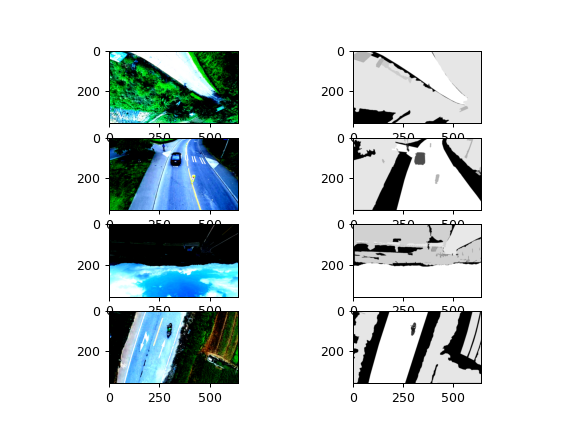

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [42]:
plt.figure()
plt.subplot(4,2,1)
plt.imshow(np.transpose(img1,(1,2,0)))
plt.subplot(4,2,3)
plt.imshow(np.transpose(img2,(1,2,0)))
plt.subplot(4,2,5)
plt.imshow(np.transpose(img3,(1,2,0)))
plt.subplot(4,2,7)
plt.imshow(np.transpose(img4,(1,2,0)))


plt.subplot(4,2,2)
plt.imshow(np.reshape(msk1,(sz1,sz2)),cmap='gray')
plt.subplot(4,2,4)
plt.imshow(np.reshape(msk2,(sz1,sz2)),cmap='gray')
plt.subplot(4,2,6)
plt.imshow(np.reshape(msk3,(sz1,sz2)),cmap='gray')
plt.subplot(4,2,8)
plt.imshow(np.reshape(msk4,(sz1,sz2)),cmap='gray')


plt.show()

In [62]:
num_classes=12
model_ft = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model_ft.classifier = DeepLabHead(2048, num_classes)

for param in model_ft.backbone.parameters():
    param.requires_grad = False
    
for param in model_ft.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [44]:
#reload last saved weights
#model_ft.load_state_dict(torch.load("./model/deeplabv3Resnet101_all_1e1_adam_10_300_525_stage_1.pth"))

<All keys matched successfully>

In [63]:
# construct an optimizer
params = [p for p in model_ft.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.AdamW(params, lr=3e-3, weight_decay=0.0005)

In [64]:
# and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15,gamma=0.1)

#lr_scheduler = CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-3,cycle_momentum = False)
#lr_scheduler = CyclicLR(optimizer, base_lr=1e-3, max_lr=1e-2,cycle_momentum = True)

num_epochs = 1
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch)
    lr_scheduler.step()

In [65]:
def train_model(model, optimizer, dataloaders, device, scheduler=None, num_epochs=25, print_freq=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e15

    #loss_func = FocalLoss() #
    loss_func = SemanticSegmentationLoss() 
    #loss_func = nn.CrossEntropyLoss()
    #loss_func = nn.MSELoss(reduction='mean')
    epoch_losses_train = []
    epoch_losses_val = []
    for epoch in range(num_epochs):
        print('\n ------------------- \n ')
        print('Epoch: ',str(epoch))
        loss_history = {'train': [], 'val': []}
        
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
            else:
                model.eval()   # Set model to evaluate mode
             
            batch_losses = []
             # Iterate over data.
            for step,(images,msks) in enumerate(dataloaders[phase]) :
                imgs = images.to(device)
                msks = msks.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(imgs)
                    #loss = loss_func(outputs['out'][:,:, :, :].uniform_().softmax(dim=1), msks.unsqueeze(1))
                    loss = loss_func(outputs['out'], msks.long())
                    #backward + optimize only if in training phase
                    loss_value = loss.data.cpu().numpy()
                    batch_losses.append(loss_value)
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
            epoch_loss =  np.mean(batch_losses)
            if phase == 'train':
                scheduler.step()
                epoch_losses_train.append(epoch_loss)
                print('\nTrain Loss: {:.6f}'.format(epoch_loss))

            else:
                epoch_losses_val.append(epoch_loss)
                print('\nVal Loss: {:.6f}'.format(epoch_loss))


            if (epoch + 1) % print_freq == 0:
                #print('Epoch: [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, epoch_loss))
                loss_history[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    print('------------------------------.....')
    print('Training complete..................')
    print('............copying model .........')


    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_history,epoch_losses_train,epoch_losses_val

In [ ]:
total_epoch = 3
model_ft, lossDictSpan,epoch_losses_train,epoch_losses_val = train_model(model_ft, optimizer, dataloaders, device, lr_scheduler, total_epoch)



 ------------------- 
 
Epoch:  0

Train Loss: 1.796308

Val Loss: 1.366744

 ------------------- 
 
Epoch:  1

Train Loss: 1.334319

Val Loss: 1.104895

 ------------------- 
 
Epoch:  2


In [21]:
torch.save(model_ft.state_dict(), './model/deeplabv3Resnet101_all_1e1_adam_10_300_525_stage_1.pth')
#torch.cuda.empty_cache()

In [22]:
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.to(torch.device('cuda'))
model_ft.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [23]:
#model_ft.load_state_dict(torch.load("./model/deeplabv3Resnet101_all_loss_12_1e1.pth"))


In [24]:
test_data = ImageData(df=test_df,root_image='./data_all/imgs/imgs/',mode='test')

In [26]:
def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)


In [27]:
def mask2rle(img,fname):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''   
    for j in range(12):        
        pixel= img.T.flatten()
        runs = np.where(pixel == j)[0]
        fn = str ('\n'+fname + "_"+ str(j))
        f.write(fn + ',')
        if len(runs) != 0:
            cons = consecutive(runs)
            for i in range(len(cons[:])):
                index = cons[i][0] 
                count = len(cons[i])
                f.write(str(index))
                f.write(' ')
                f.write(str(count))
                f.write(' ')
            continue
    return

In [28]:
model_ft.to('cuda')
f= open("./sub_24_300_525.csv","a+",encoding = "UTF-8")
f.write("ImageID" + ',' "EncodedPixels") 

for i in range(len(test_data)):
    input_fname,img = test_data.__getitem__(i)
    input_image_t = torch.tensor(img,dtype=torch.float)
    input_image = input_image_t.unsqueeze(0)
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_image = input_image.to('cuda')

    with torch.no_grad():
        output = model_ft(input_image)['out'][0]
    output_predictions = output.argmax(0)
    head, tail = os.path.split(input_fname)
    fn=tail.split('.jpg')
    mask2rle(output_predictions.cpu().detach().numpy(),fn[0])
    
f.close()

/media/hdd/tools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


#sample test

In [76]:
j=250
input_fname,img = test_data.__getitem__(j)
input_plt = np.asarray(Image.open(input_fname))
#input_2 =np.reshape(input_1,(3,720,1280))
input_image_t = torch.tensor(img,dtype=torch.float)
print(input_image_t.shape)
input_image = input_image_t.unsqueeze(0)
print(input_image.shape)

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_image = input_image.to('cuda')
print(input_image.shape)

with torch.no_grad():
    output = model_ft(input_image)['out'][0]
output_predictions = output.argmax(0)

torch.Size([3, 720, 1280])
torch.Size([1, 3, 720, 1280])
torch.Size([1, 3, 720, 1280])


/media/hdd/tools/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


<IPython.core.display.Javascript object>


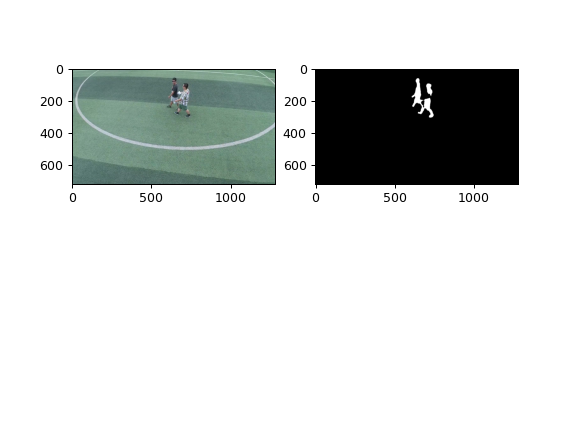

In [77]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(input_plt)

plt.subplot(2,2,2)
plt.imshow(output_predictions.cpu(),cmap='gray')


plt.show()